# Restless Calibration and Randomized Benchmarking

In this tutorial we demonstrate restless calibration experiments to calibrate the amplitude and DRAG parameter of a `SX` pulse on `ibmq_bogota`. These experiments are also demonstrated in the [tutorial](https://github.com/Qiskit/qiskit-experiments/blob/main/docs/tutorials/calibrating_armonk.ipynb) that shows calibration of single-qubit gates on `ibmq_armonk` with the key difference being that in our experiments the qubit is not reset after a measurement. We also show fine calibration experiments that iteratively find the best amplitude and DRAG parameter values. After we performed the calibration experiments we characterize our calibrated `SX` pulse using restless randomized benchmarking (RB) to determine the fidelity of our pulse, see also the corresponding [tutotial](https://github.com/Qiskit/qiskit-experiments/blob/main/docs/tutorials/randomized_benchmarking.ipynb).

1. What is a restless experiment?
2. Restless rough amplitude calibration
3. Restless rough DRAG parameter caibration
4. Closed loop restless fine amplitude calibration
5. Closed loop restless fine DRAG parameter calibration
6. Restless RB
7. Restless speed-up

## 1. What is a restless experiment?

Usually, when running circuits on a quantum device, the qubits are reset to the ground state after each measurement to ensure a well-defined initial state for the next circuit. This can be done passively by waiting several $T_1$-times such that a qubit decays due to the interaction with the environment if it was in the excited state. Since the $T_1$-times have continuously been improved (they already increased beyond $100 \mu$s), this initialization procedure becomes time-consuming and inefficient. 
This makes active reset necessary - and this is how qubits are reset on the IBM Quantum devices. Actively reseting qubits is more efficient and saves time but also lasts a few microseconds (between $3$ and $5 \mu$s). Furthermore, a delay (typically $250 \mu$s) after the reset operation is often necessary to ensure a high initialization quality.

However, for several types of experiments, e.g. calibration, a reset is not needed and we can directly continue with the subsequent circuit after a short delay time, even if the qubit was measured in the excited state. This is the idea of a restless measurement. 

The IBM Quantum devices have dynamical repetition delays enabled. This means that we can choose the delay after a circuit in a range of delays, typically 0 to 500$\mu$s. The default value is for most of the devices 250$\mu$s. Our aim will be to set this delay to a small value of 1$\mu$s.

In [1]:
from qiskit import IBMQ
IBMQ.load_account()

provider = IBMQ.get_provider(hub='ibm-q-internal', group='deployed', project='default')

backend = provider.get_backend('ibmq_bogota')

config = backend.configuration()
defaults = backend.defaults()

print(f'We can choose repetition delays in the range from {config.rep_delay_range[0]} to {config.rep_delay_range[1]/1e-6:.1f} microseconds.')
print(f'The default repetition delay for ibmq_bogota is {config.default_rep_delay/1e-6:.1f} microseconds.')

We can choose repetition delays in the range from 0.0 to 500.0 microseconds.
The default repetition delay for ibmq_bogota is 250.0 microseconds.


Not reseting the qubit to the ground state implies that the qubit can be either in the $|0\rangle$ or in the $|1\rangle$ state for the next circuit. Therefore, the measured outcomes of the restless experiments require post-processing. Defining an experiment with restless run options will automatically enable this required postprocessing before the experiment results are analyzed. 

The following run options define a restless experiment:
1. Set the `rep_delay` to a small value, e.g. $1 \mu$s.
2. Ensure that the qubit is not reset to the ground state throughout the experiment: `init_qubits=False`.
3. Set `memory=True` to ensure that the single measurement shots are returned. This is needed for post-processing.
4. Set `meas_level=2`.

E.g., for an artificial experiment:

```python
restless_experiment = MyExperiment(...)
restless_experiment.set_run_options(rep_delay=1e-6, meas_level=2, memory=True, init_qubits=False)
```

The circuits are now executed without reseting the qubit after a measurement. The subsequent circuit is run after a delay of $1 \mu$s.

This tutorial shows that we can perform amplitude and DRAG parameter calibrations, as well as RB, in a restless setting which leads to a significantly reduced experiment duration compared to the respective standard calibration experiment with active resets.

In [2]:
import numpy as np
import pandas as pd

from qiskit import QuantumCircuit, transpile, schedule
import qiskit.pulse as pulse
from qiskit.circuit import Parameter

In [3]:
qubit = 2 # The qubit we will work with

In [4]:
rep_delay = 1e-6 # The restless repetition delay we will work with

Similar to this [tutorial](https://github.com/Qiskit/qiskit-experiments/blob/main/docs/tutorials/calibrating_armonk.ipynb) we use the pre-built library of gates which provides a standard set of gates and some initial guesses for the value of the parameters in the template schedules. This is shown below using the `FixedFrequencyTransmon` which provides the `x`, `y`, `sx`, and `sy` pulses.

Note that the values of the parameters stored in the instance of the `Calibrations` class will automatically be updated by the calibration experiments. This automatic updating can also be disabled using the `auto_update` flag.

In [5]:
from qiskit_experiments.calibration_management.basis_gate_library import FixedFrequencyTransmon
from qiskit_experiments.calibration_management.calibrations import Calibrations

In [6]:
library = FixedFrequencyTransmon()
cals = Calibrations.from_backend(backend, library)

In [7]:
pd.DataFrame(**cals.parameters_table(qubit_list=[qubit, ()]))

,parameter,qubits,schedule,value,group,valid,date_time,exp_id
0,σ,(),x,4.000000e+01,default,True,2022-01-23 14:18:58.296311+0100,None
1,σ,(),sx,4.000000e+01,default,True,2022-01-23 14:18:58.296399+0100,None
2,amp,(),x,5.000000e-01,default,True,2022-01-23 14:18:58.296278+0100,None
3,duration,(),x,1.600000e+02,default,True,2022-01-23 14:18:58.296343+0100,None
4,β,(),x,0.000000e+00,default,True,2022-01-23 14:18:58.296379+0100,None
5,duration,(),sx,1.600000e+02,default,True,2022-01-23 14:18:58.296412+0100,None
6,meas_freq,"(2,)",None,7.334794e+09,default,True,2022-01-23 14:18:59.186967+0100,None
7,drive_freq,"(2,)",None,4.782947e+09,default,True,2022-01-23 14:18:59.186922+0100,None
8,amp,(),sx,2.500000e-01,default,True,2022-01-23 14:18:58.296424+0100,None
9,β,(),sx,0.000000e+00,default,True,2022-01-23 14:18:58.296435+0100,None


## 2. Restless rough amplitude calibration

In the Rabi experiment we apply a pulse at the frequency of the qubit and scan its amplitude to find the amplitude that creates a rotation of a desired angle. We do this with the calibration experiment `RoughXSXAmplitudeCal`. This is a specialization of the `Rabi` experiment that will update the calibrations for both the `X` pulse and the `SX` pulse using a single experiment.

In [8]:
from qiskit_experiments.library.calibration import RoughXSXAmplitudeCal

In [9]:
rabi_restless = RoughXSXAmplitudeCal(qubit, cals, backend=backend)

# set the restless run options
rabi_restless.set_run_options(rep_delay=rep_delay, meas_level=2, memory=True, init_qubits=False)

The rough amplitude calibration is therefore a Rabi experiment in which each circuit contains a pulse with a gate. Different circuits correspond to pulses with different amplitudes.

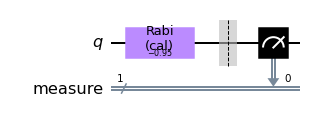

In [10]:
rabi_restless.circuits()[0].draw("mpl")

In [11]:
rabi_data_restless = rabi_restless.run()

In [12]:
rabi_data_restless

<ExperimentData[RoughXSXAmplitudeCal], backend: ibmq_bogota, status: DONE, experiment_id: b053d706-7ca3-4088-b230-c8d007cb0e6a>

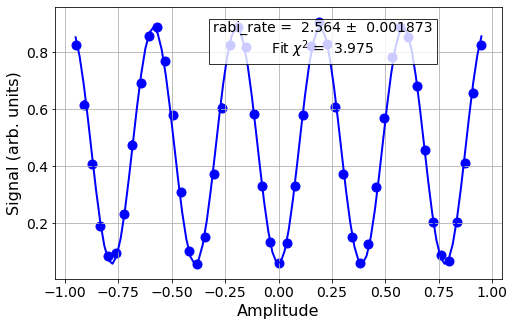

In [13]:
rabi_data_restless.figure(0)

In [14]:
print(rabi_data_restless.analysis_results("rabi_rate"))

DbAnalysisResultV1
- name: rabi_rate
- value: 2.564086606131548 ± 0.0018729627282602463
- χ²: 3.975023173907326
- quality: bad
- device_components: ['Q2']
- verified: False


In [15]:
pd.DataFrame(**cals.parameters_table(qubit_list=[qubit, ()], parameters="amp"))

,parameter,qubits,schedule,value,group,valid,date_time,exp_id
0,amp,(),x,0.500000+0.000000j,default,True,2022-01-23 14:18:58.296278+0100,None
1,amp,"(2,)",sx,0.097501+0.000000j,default,True,2022-01-23 14:27:54.271000+0100,b053d706-7ca3-4088-b230-c8d007cb0e6a
2,amp,"(2,)",x,0.195001+0.000000j,default,True,2022-01-23 14:27:54.271000+0100,b053d706-7ca3-4088-b230-c8d007cb0e6a
3,amp,(),sx,0.250000+0.000000j,default,True,2022-01-23 14:18:58.296424+0100,None


The table above shows that we have now updated the amplitude of our 
π/2-pulse from 0.25 to the value obtained in the most recent Rabi experiment.

In [16]:
cals.get_schedule("sx", qubit).instructions[0][-1]

Play(Drag(duration=160, amp=(0.09750061+0j), sigma=40, beta=0), DriveChannel(2))

## 3. Restless rough DRAG calibration

A Derivative Removal by Adiabatic Gate (DRAG) pulse is designed to minimize leakage to a neighbouring transition. It is a standard pulse with an additional derivative component. It is designed to reduce the frequency spectrum of a normal pulse near the $|1\rangle$-$|2\rangle$ transition, reducing the chance of leakage to the $|2\rangle$ state. The optimal value of the DRAG parameter $\beta$ is chosen to minimize both leakage and phase errors resulting from the AC Stark shift.

The DRAG calibration will run several series of circuits. In a given circuit a Rp(β) - Rm(β) block is repeated $N$
 times. Here, Rp is a rotation with a positive angle and Rm is the same rotation with a negative amplitude.

In [17]:
from qiskit_experiments.library import RoughDragCal

### Consistency check:

To show that we indeed need post-processing of restless experiment data, we can run a restless `RoughDragCal` experiment but specifiy a standard data processor. As we would expect, we get a useless result:

In [ ]:
from qiskit_experiments.data_processing.data_processor import DataProcessor
from qiskit_experiments.data_processing.nodes import Probability

In [ ]:
# define a standard data processor.
standard_processor = DataProcessor("counts", [Probability("1")])

cal_drag_restless_standard_proc = RoughDragCal(qubit, cals, schedule_name='sx', backend=backend, 
                                         betas=np.linspace(-25, 25, 25))

cal_drag_restless_standard_proc.set_experiment_options(reps=[3, 5, 7])

# set the restless run options
cal_drag_restless_standard_proc.set_run_options(rep_delay=rep_delay, meas_level=2, memory=True, init_qubits=False)

# specify the standard data processor in the analysis options.
restless_cal_drag_standard_proc.set_analysis_options(data_processor=standard_processor)

Let us continue our `SX` pulse calibration with the restless `RoughDragCal` experiment that is correctly anayzed and gives useful results:

In [29]:
cal_drag_restless = RoughDragCal(qubit, cals, schedule_name='sx', backend=backend, betas=np.linspace(-25, 25, 25))

cal_drag_restless.set_experiment_options(reps=[3, 5, 7])

# set the restless run options
cal_drag_restless.set_run_options(rep_delay=rep_delay, meas_level=2, memory=True, init_qubits=False)

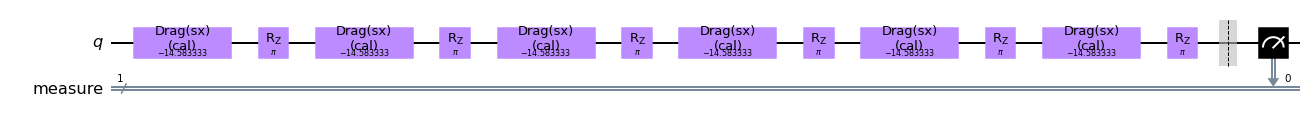

In [30]:
cal_drag_restless.circuits()[5].draw(output='mpl', fold=True)

In [31]:
drag_data_restless = cal_drag_restless.run()

In [33]:
drag_data_restless

<ExperimentData[RoughDragCal], backend: ibmq_bogota, status: DONE, experiment_id: 512dcb79-5bbf-49f6-8d9c-146e77c301bb>

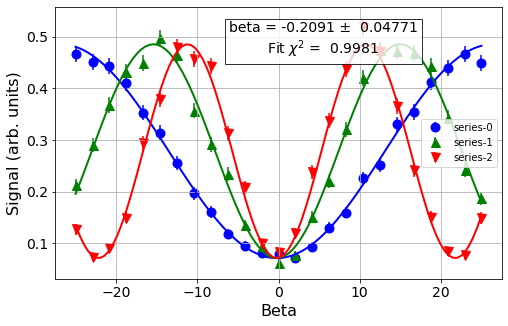

In [34]:
drag_data_restless.figure(0)

In [35]:
print(drag_data_restless.analysis_results("beta"))

DbAnalysisResultV1
- name: beta
- value: -0.2090561851035645 ± 0.04770711990685729
- χ²: 0.9980803993930224
- quality: good
- device_components: ['Q2']
- verified: False


In [36]:
pd.DataFrame(**cals.parameters_table(qubit_list=[qubit, ()], parameters="β"))

,parameter,qubits,schedule,value,group,valid,date_time,exp_id
0,β,"(2,)",sx,-0.209056,default,True,2022-01-23 15:14:24.603000+0100,512dcb79-5bbf-49f6-8d9c-146e77c301bb
1,β,(),x,0.000000,default,True,2022-01-23 14:18:58.296379+0100,None
2,β,(),sx,0.000000,default,True,2022-01-23 14:18:58.296435+0100,None


In [37]:
cals.get_schedule("sx", qubit).instructions[0][-1]

Play(Drag(duration=160, amp=(0.09750061+0j), sigma=40, beta=-0.2090561851), DriveChannel(2))

## 4. Closed loop restless fine amplitude calibration

Using the restless `RoughXSXAmplitudeCal` and `RoughDragCal` experiments we were able to find good first estimates for the amplitude and the DRAG parameter $\beta$ of the `SX` pulse. In the following we use these parameters as starting values for iterative `FineSXAmplitudeCal` and `FineSXDragCal` calibration experiments where the calibrated pulse parameter is updated after each iteration. Each experiment is repeated until the measured deviation angle ${\rm d}\theta$ is below a given tolerance or a maximum number of iterations is exceeded.

The `FineAmplitude` calibration experiment repeats $N$ times a gate with a pulse to amplify the under or over-rotations in the gate to determine the optimal amplitude. The circuits that are run have a custom gate with the pulse schedule attached to it through the calibrations.

In [38]:
from qiskit_experiments.library.calibration.fine_amplitude import FineSXAmplitudeCal

In [39]:
def amp_closed_loop(qubit, dtheta_tol, backend, pulse_name, target_angle, starting_amp, min_rounds=3):
    """Closed loop fine amplitude calibration experiment.
    
    Args:
        qubit: The qubit we are working with.
        dtheta_tol: The tolerance value for the deviation angle.
        pulse_name: The name of the pulse that is calibrated.
        target_angle: The target angle corresponding to the pulse.
        starting_amp: The initial amplitude value for the iterative calibration.
        min_rounds: Minimum number of iterations. 
    """
    
    dtheta = np.inf
    backend_pulse = cals.get_schedule(pulse_name, qubit).instructions[0][1].pulse
    
    ideal_amp = backend_pulse.amp
    pulse_amp = starting_amp
    print(f"The reported amplitude of the SX pulse is {ideal_amp:.4f}.")
    
    rounds_done = 0
    while abs(dtheta) > dtheta_tol or rounds_done < min_rounds:
        
        print(f"Running with amplitude={pulse_amp:.4f}")
        print("Current calibrated pulse:", cals.get_schedule("sx", qubit).instructions[0][-1])
        
        amp_cal = FineSXAmplitudeCal(qubit, cals, backend=backend, schedule_name="sx")
        
        # set the restless run options
        amp_cal.set_run_options(rep_delay=rep_delay, meas_level=2, memory=True, init_qubits=False)
        
        amp_data = amp_cal.run().block_for_results()
        
        dtheta = amp_data.analysis_results("d_theta").value.value
        
        display(amp_data.figure(0))
        print(amp_data.analysis_results("d_theta"))

        scale = target_angle / (target_angle + dtheta)
        pulse_amp = pulse_amp * scale

        rounds_done += 1

In [40]:
rough_amp = cals.get_schedule("sx", qubit).instructions[0][1].pulse.amp
rough_amp

(0.09750061+0j)

We choose a tolerance value of `dtheta_tol=0.001` and the minimum number of iterations `min_rounds=3`. The target angle for a `SX` gate is $\pi / 2$.

The reported amplitude of the SX pulse is 0.0975+0.0000j.
Running with amplitude=0.0975+0.0000j
Current calibrated pulse: Play(Drag(duration=160, amp=(0.09750061+0j), sigma=40, beta=-0.2090561851), DriveChannel(2))


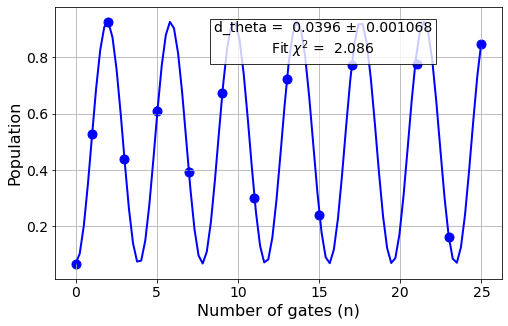

DbAnalysisResultV1
- name: d_theta
- value: 0.03960049222180869 ± 0.0010682854629736071
- χ²: 2.0862021414606624
- quality: good
- device_components: ['Q2']
- verified: False
Running with amplitude=0.0951+0.0000j
Current calibrated pulse: Play(Drag(duration=160, amp=(0.0951030195+0j), sigma=40, beta=-0.2090561851), DriveChannel(2))


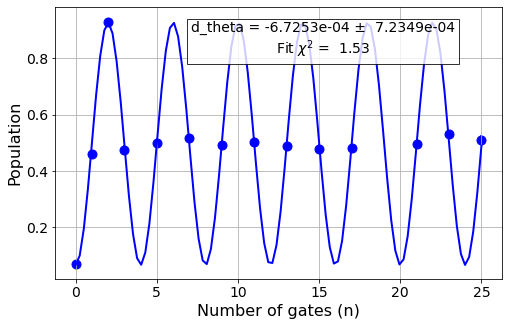

DbAnalysisResultV1
- name: d_theta
- value: -0.0006725250530884178 ± 0.0007234928309953916
- χ²: 1.5296170540793161
- quality: good
- device_components: ['Q2']
- verified: False
Running with amplitude=0.0951+0.0000j
Current calibrated pulse: Play(Drag(duration=160, amp=(0.0951437546+0j), sigma=40, beta=-0.2090561851), DriveChannel(2))


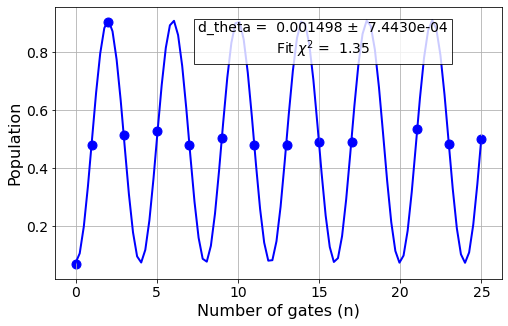

DbAnalysisResultV1
- name: d_theta
- value: 0.0014982489007180568 ± 0.0007443012723571133
- χ²: 1.3504996597287262
- quality: good
- device_components: ['Q2']
- verified: False
Running with amplitude=0.0951+0.0000j
Current calibrated pulse: Play(Drag(duration=160, amp=(0.0950530915+0j), sigma=40, beta=-0.2090561851), DriveChannel(2))


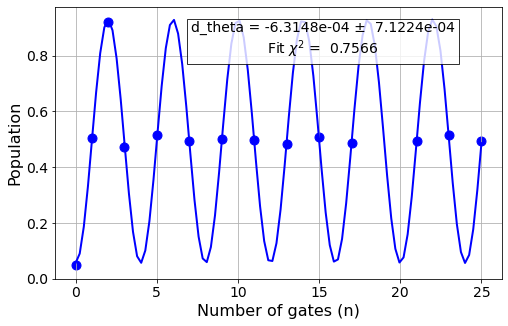

DbAnalysisResultV1
- name: d_theta
- value: -0.0006314788421978782 ± 0.0007122419708226792
- χ²: 0.7565899574180878
- quality: good
- device_components: ['Q2']
- verified: False


In [41]:
amp_closed_loop(qubit=qubit, 
                 dtheta_tol=0.001, 
                 backend=backend, 
                 pulse_name="sx",
                 target_angle=np.pi / 2, 
                 starting_amp=rough_amp, 
                 min_rounds=3)

In [42]:
pd.DataFrame(**cals.parameters_table(qubit_list=[qubit, ()]))

,parameter,qubits,schedule,value,group,valid,date_time,exp_id
0,amp,"(2,)",sx,9.509132e-02+0.000000e+00j,default,True,2022-01-23 15:26:44.364000+0100,0713d6f9-8fe9-41f8-afcd-475e4107d820
1,β,"(2,)",sx,-2.090562e-01+0.000000e+00j,default,True,2022-01-23 15:14:24.603000+0100,512dcb79-5bbf-49f6-8d9c-146e77c301bb
2,σ,(),x,4.000000e+01+0.000000e+00j,default,True,2022-01-23 14:18:58.296311+0100,None
3,σ,(),sx,4.000000e+01+0.000000e+00j,default,True,2022-01-23 14:18:58.296399+0100,None
4,amp,(),x,5.000000e-01+0.000000e+00j,default,True,2022-01-23 14:18:58.296278+0100,None
5,duration,(),x,1.600000e+02+0.000000e+00j,default,True,2022-01-23 14:18:58.296343+0100,None
6,β,(),x,0.000000e+00+0.000000e+00j,default,True,2022-01-23 14:18:58.296379+0100,None
7,duration,(),sx,1.600000e+02+0.000000e+00j,default,True,2022-01-23 14:18:58.296412+0100,None
8,meas_freq,"(2,)",None,7.334794e+09+0.000000e+00j,default,True,2022-01-23 14:18:59.186967+0100,None
9,drive_freq,"(2,)",None,4.782947e+09+0.000000e+00j,default,True,2022-01-23 14:18:59.186922+0100,None


In [43]:
cals.get_schedule("sx", qubit).instructions[0][-1]

Play(Drag(duration=160, amp=(0.0950913194+0j), sigma=40, beta=-0.2090561851), DriveChannel(2))

## 5. Closed loop restless fine DRAG calibration

Analogously, we perform an iterative `FineSXDragCal` calibration experiment.

In [44]:
from qiskit_experiments.library.calibration import FineSXDragCal

In [45]:
def drag_closed_loop(qubit, dtheta_tol, backend, pulse_name, target_angle, starting_beta, min_rounds=3):
    """Closed loop fine calibration experiment.
    
    Args:
        qubit: The qubit we are working with.
        dtheta_tol: The tolerance value for the deviation angle.
        pulse_name: The name of the pulse that is calibrated.
        target_angle: The target angle corresponding to the pulse.
        starting_beta: The initial beta value for the iterative calibration.
        min_rounds: Minimum number of iterations.
    """    
    dtheta = np.inf
    backend_pulse = cals.get_schedule(pulse_name, qubit).instructions[0][1].pulse

    ideal_beta = backend_pulse.beta
    cal_beta = starting_beta
    print(f"The reported beta of the {pulse_name} pulse is {ideal_beta:.4f}.")
    
    rounds_done = 0
    while abs(dtheta) > dtheta_tol or rounds_done < min_rounds:
        
        print(f"Running with beta={cal_beta:.4f}")
        print("Current cal. pulse:", cals.get_schedule("sx", qubit).instructions[0][-1])
            
        drag_cal = FineSXDragCal(qubit, cals, backend=backend)
        
        # set the restless run options
        drag_cal.set_run_options(rep_delay=rep_delay, meas_level=2, memory=True, init_qubits=False)
        
        drag_data = drag_cal.run(backend)
        drag_data.block_for_results()
        
        dtheta = drag_data.analysis_results("d_theta").value.value
        
        display(drag_data.figure(0))
        print(drag_data.analysis_results("d_theta"))
        
        dbeta = -np.sqrt(np.pi) * dtheta * backend_pulse.sigma / target_angle ** 2
        cal_beta = cal_beta + dbeta
        rounds_done += 1

In [46]:
rough_beta = cals.get_schedule("sx", qubit).instructions[0][1].pulse.beta
rough_beta

-0.2090561851

We choose a tolerance value of `dtheta_tol=0.01` and the minimum number of iterations `min_rounds=3`. 

The reported beta of the sx pulse is -0.2091.
Running with beta=-0.2091
Current cal. pulse: Play(Drag(duration=160, amp=(0.0950913194+0j), sigma=40, beta=-0.2090561851), DriveChannel(2))


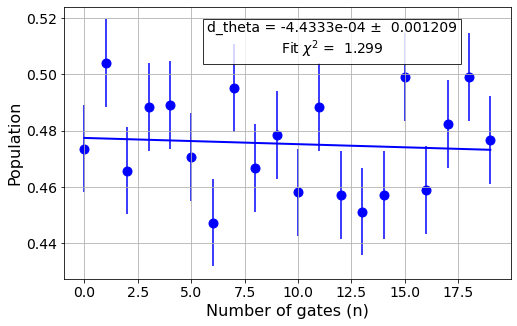

DbAnalysisResultV1
- name: d_theta
- value: -0.00044333324344791083 ± 0.001209185293530721
- χ²: 1.2992895417823225
- quality: good
- device_components: ['Q2']
- verified: False
Running with beta=-0.1963
Current cal. pulse: Play(Drag(duration=160, amp=(0.0950913194+0j), sigma=40, beta=-0.1963174745), DriveChannel(2))


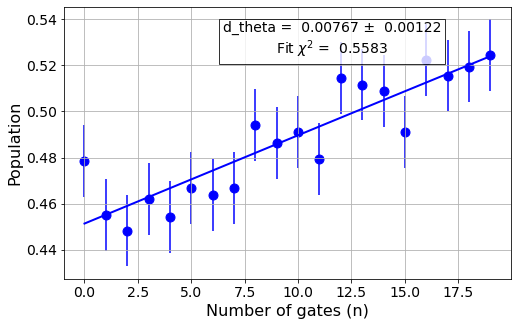

DbAnalysisResultV1
- name: d_theta
- value: 0.007669552670859051 ± 0.0012201586395118788
- χ²: 0.5582538507243394
- quality: good
- device_components: ['Q2']
- verified: False
Running with beta=-0.4167
Current cal. pulse: Play(Drag(duration=160, amp=(0.0950913194+0j), sigma=40, beta=-0.4166939372), DriveChannel(2))


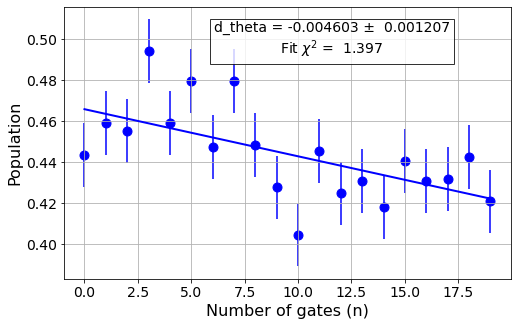

DbAnalysisResultV1
- name: d_theta
- value: -0.004603068691734917 ± 0.0012066567992468117
- χ²: 1.3966983572813578
- quality: good
- device_components: ['Q2']
- verified: False


In [47]:
drag_closed_loop(qubit=qubit, 
                  dtheta_tol=0.01, 
                  backend=backend, 
                  pulse_name="sx", 
                  target_angle = np.pi / 2, 
                  starting_beta=rough_beta, 
                  min_rounds=3)

In [48]:
pd.DataFrame(**cals.parameters_table(qubit_list=[qubit, ()]))

,parameter,qubits,schedule,value,group,valid,date_time,exp_id
0,amp,"(2,)",sx,9.509132e-02+0.000000e+00j,default,True,2022-01-23 15:26:44.364000+0100,0713d6f9-8fe9-41f8-afcd-475e4107d820
1,β,"(2,)",sx,-2.844296e-01+0.000000e+00j,default,True,2022-01-23 15:50:24.568000+0100,887806ca-ed2f-42ff-84ce-b9a6f5781a9b
2,σ,(),x,4.000000e+01+0.000000e+00j,default,True,2022-01-23 14:18:58.296311+0100,None
3,σ,(),sx,4.000000e+01+0.000000e+00j,default,True,2022-01-23 14:18:58.296399+0100,None
4,amp,(),x,5.000000e-01+0.000000e+00j,default,True,2022-01-23 14:18:58.296278+0100,None
5,duration,(),x,1.600000e+02+0.000000e+00j,default,True,2022-01-23 14:18:58.296343+0100,None
6,β,(),x,0.000000e+00+0.000000e+00j,default,True,2022-01-23 14:18:58.296379+0100,None
7,duration,(),sx,1.600000e+02+0.000000e+00j,default,True,2022-01-23 14:18:58.296412+0100,None
8,meas_freq,"(2,)",None,7.334794e+09+0.000000e+00j,default,True,2022-01-23 14:18:59.186967+0100,None
9,drive_freq,"(2,)",None,4.782947e+09+0.000000e+00j,default,True,2022-01-23 14:18:59.186922+0100,None


Finally, we can print the pulse schedule corresponding to our calibrated `SX` pulse.

In [49]:
cals.get_schedule("sx", qubit).instructions[0][1].pulse

Drag(duration=160, amp=(0.0950913194+0j), sigma=40, beta=-0.2844296397)

In [50]:
backend.defaults().instruction_schedule_map.get('sx', (qubit,)).instructions[0][1].pulse

Drag(duration=160, amp=(0.09511226353590134+0.0009580085705362655j), sigma=40, beta=-0.40318639727369376, name='X90p_d2')

## 6. Restless Randomized Benchmarking

Finally, we determine the error per `SX` gate using RB where RB is also an experiment that can be performed in a restless setting without qubit reset. Similar to the calibration experiments we need to define the restless run options. For further details on RB we refer to the [tutorial](https://github.com/Qiskit/qiskit-experiments/blob/main/docs/tutorials/randomized_benchmarking.ipynb) and the [Qiskit Textbook](https://qiskit.org/textbook/ch-quantum-hardware/randomized-benchmarking.html). 

In [51]:
from qiskit_experiments.library import StandardRB

from qiskit_experiments.data_processing.data_processor import DataProcessor
from qiskit_experiments.data_processing.nodes import RestlessToCounts, Probability

In [52]:
lengths = np.arange(1, 1600, 100)
num_samples = 10
seed = 1010
qubits = [qubit]

In [53]:
# Run a restless RB experiment
rb_exp_restless = StandardRB(qubits, lengths, num_samples=num_samples, seed=seed)

# set the restless run options
rb_exp_restless.set_run_options(rep_delay=rep_delay, meas_level=2, memory=True, init_qubits=False)
# transpile gates to SX and Rz gates based on the calibrations
rb_exp_restless.set_transpile_options(basis_gates=["sx", "rz"], inst_map=cals.default_inst_map)

# restless data processor for RB
restless_processor_rb = DataProcessor("memory", [RestlessToCounts(header={"memory_slots": 1}), Probability("0")])
rb_exp_restless.set_analysis_options(data_processor=restless_processor_rb)

In [54]:
expdata_restless = rb_exp_restless.run(backend)

In [62]:
expdata_restless

<ExperimentData[StandardRB], backend: ibmq_bogota, status: DONE, experiment_id: d13103a8-e3bf-4c59-a454-b29eb7c49a89>

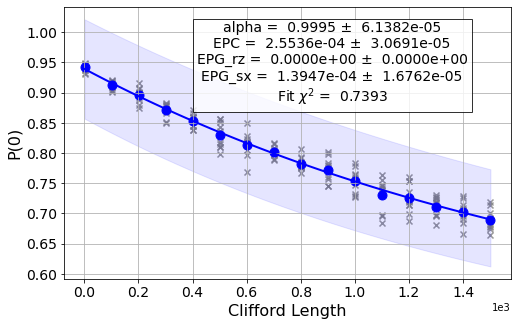

DbAnalysisResultV1
- name: @Parameters_RBAnalysis
- value: [0.46563692 0.99948928 0.47371513] ± [4.07214152e-02 6.13815208e-05 4.14509923e-02]
- χ²: 0.7393430923992711
- extra: <4 items>
- device_components: ['Q2']
- verified: False
DbAnalysisResultV1
- name: alpha
- value: 0.9994892761679656 ± 6.13815207931731e-05
- χ²: 0.7393430923992711
- device_components: ['Q2']
- verified: False
DbAnalysisResultV1
- name: EPC
- value: 0.00025536191601721603 ± 3.069076039658655e-05
- χ²: 0.7393430923992711
- device_components: ['Q2']
- verified: False
DbAnalysisResultV1
- name: EPG_rz
- value: 0.0 ± 0.0
- χ²: 0.7393430923992711
- device_components: ['Q2']
- verified: False
DbAnalysisResultV1
- name: EPG_sx
- value: 0.000139470339024348 ± 1.676229104240579e-05
- χ²: 0.7393430923992711
- device_components: ['Q2']
- verified: False


In [63]:
rb_results = expdata_restless.analysis_results()

# View result data
display(expdata_restless.figure(0))
for result in rb_results:
    print(result)

## 7. Compute the restless speed-up

Finally, we compare the time spent by the quantum processor executing restless and standard jobs. This allows us to compute the effective speed-up we gain when performing restless experiments. Note that we do not consider any classical run-time contributions such as runtime-compilation or data transfer times.

We compute the respective times as:

$\tau^{(x)}=NK\left(\tau^{(x)}_\text{reset}+\tau^{(x)}_\text{delay}+\langle{\tau}_\text{circ}\rangle+\tau_\text{meas}\right)$, 

where $\tau^{(x)}_\text{reset}$ and $\tau^{(x)}_\text{delay}$ are the reset and delay times, respectively, and $N$ is the number of shots.
The superscript $(x)$ indicates restless $(r)$ or standard $(s)$ measurements.
The average duration of all $K$ circuits in an experiment is $\langle{\tau}_\text{circ}\rangle=K^{-1}\sum_{k=1}^{K} \tau_{\text{circ},k}$ where $\tau_{\text{circ},k}$ is the duration of only the gates in circuit $k$.
We therefore compute the quantum processor speed-up of restless measurements as $\tau^{(\text{s})}/\tau^{(\text{r})}$ which is independent of the number of circuits and shots.

The standard reset time is on average $\tau^{(s)}_\text{reset} = 4\mu s$ whereas $\tau^{(r)}_\text{reset} = 0\mu s$ since we do not reset the qubit in a restless experiment. By default, the repetition delay is $\tau^{(s)}_\text{delay} = 250\mu s$. For our restless experiments we set $\tau^{(r)}_\text{delay} = 1\mu s$.

In [66]:
def compute_total_duration(experiment, qubit, reset, rep_delay, meas_length=5.0e-6, shots=1024):
    """Compute the time the quantum processor takes to execute the experiment circuits.
    Args:
        experiment: The experiment, e.g. RoughDragCal.
        qubit: The qubit we are working with.
        reset: The duration of the reset. By default the reset takes between 3 to 5 us.
        meas_length: The duration of the measurement process. For most devices the 
                     measurement process takes 5.4 us, for
        shots: The number of shots which is by default 1024.
    Returns: The time the whole experiment takes up on the quantum processor.
    """
    # Duration of one sample
    dt = backend.configuration().dt
    
    durations = []

    # Compute the average duration of all circuits
    for qc in experiment.circuits():
        qc.remove_final_measurements(inplace=True)
        schedule_time = schedule(transpile(qc, backend, initial_layout=[qubit]), 
                                 backend).duration
        durations.append(schedule_time)
        
    tau = np.sum(durations) * dt / (len(durations))
    
    n_circs = len(experiment.circuits())
    
    return ((meas_length + reset + rep_delay + tau) * shots * n_circs)

In [67]:
amp_cal = FineSXAmplitudeCal(qubit, cals, backend=backend, schedule_name="sx")
drag_cal = FineSXDragCal(qubit, cals, backend=backend)

In [68]:
experiments = [rabi_restless, cal_drag_restless, amp_cal, drag_cal]#, rb_exp_restless]

for experiment in experiments:
    standard_duration = compute_total_duration(experiment, qubit, reset=4e-6, rep_delay=250e-6)
    restless_duration = compute_total_duration(experiment, qubit, reset=0, rep_delay=1e-6)
    speed_up = standard_duration / restless_duration
    print(f"The restless {experiment.experiment_type} was performed {speed_up:.1f}x faster.")

The restless RoughXSXAmplitudeCal was performed 40.3x faster.
The restless RoughDragCal was performed 38.5x faster.
The restless FineSXAmplitudeCal was performed 38.3x faster.
The restless FineSXDragCal was performed 36.6x faster.


In [69]:
import qiskit.tools.jupyter
%qiskit_copyright